*# Based on https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/ and on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from google.colab import drive


In [4]:
# #Mount Google drive
# drive.mount('/content/drive')

# #Adjust your working directory
# os.chdir('/content/drive/My Drive/Data_Projects/MDS/3rd semester/Deep learning LAB/Assignments/LSTM-time-series-tutorial')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Change to your file path
file_path = 'data/df_hourly.csv'

df_ori = pd.read_csv(file_path, index_col=['datetime'])

In [19]:
df = df_ori.copy()
df.head()

,total_real_power,reactive_power,voltage,current_intensity,kitchen,laundry_room,temp_control
datetime,,,,,,,
2006-12-16 17:00:00,152.02400,8.243999,234.64388,651.6,0.0,1.14,36.42
2006-12-16 18:00:00,217.93200,4.802000,234.58015,936.0,0.0,24.18,60.72
2006-12-16 19:00:00,204.01399,5.114000,233.23250,870.2,0.0,5.16,60.06
2006-12-16 20:00:00,196.11400,4.506000,234.07150,835.0,0.0,0.00,60.42
2006-12-16 21:00:00,183.38800,4.600000,237.15866,782.8,0.0,1.50,61.98


In [44]:
# Divide the dataset in train and test portions

# Train – Test Split
proportion = 0.75 # Choose the proportion from 0 to 1.
train_df,test_df = df[1:round(proportion*len(df))], df[round(proportion*len(df)):]

#print shaps
train_df.shape, test_df.shape

((25941, 7), (8647, 7))

In [22]:
#Scaling the values
#All the columns in the data frame are on a different scale. Now we will scale the values to -1 to 1 for faster training of the models.

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s



<ipython-input-22-be28cb0ff692>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-22-be28cb0ff692>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-22-be28cb0ff692>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [23]:
# Converting the series to samples
#Now we will make a function that will use a sliding window approach to transform our series into samples of input past observations and output future observations to use supervised learning algorithms.

def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)




In [29]:
# Define the number of days you want to predict and the window in days

n_past = 30
n_future = 5
n_features = 7

n_past *= 24
n_future *= 24



In [32]:
print(n_past, n_future, n_features)

720 120 7


In [33]:
# Build train sets - features and output
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

# Build test sets - features and output
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [35]:
# E1D1 - Sequence Model with one encoder layer and one decoder layer.
#

n_neurons = 80

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features)) # n_features ==> no of features at each timestep in the data.
encoder_l1 = tf.keras.layers.LSTM(n_neurons, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(n_neurons, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 720, 7)]             0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 100),                43200     ['input_1[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector (RepeatVecto  (None, 120, 100)             0         ['lstm[0][0]']                
 r)                                                                                           

In [36]:
### E2D2 - Sequence Model with two encoder layers and two decoder layers.

n_neurons = 80

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features)) #n_features ==> no of features at each timestep in the data.

encoder_l1 = tf.keras.layers.LSTM(n_neurons,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(n_neurons, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(n_neurons, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(n_neurons, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 720, 7)]             0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 720, 100),           43200     ['input_2[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 lstm_3 (LSTM)               [(None, 100),                80400     ['lstm_2[0][0]']              
                              (None, 100),                                                  

In [37]:
#Training the models

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

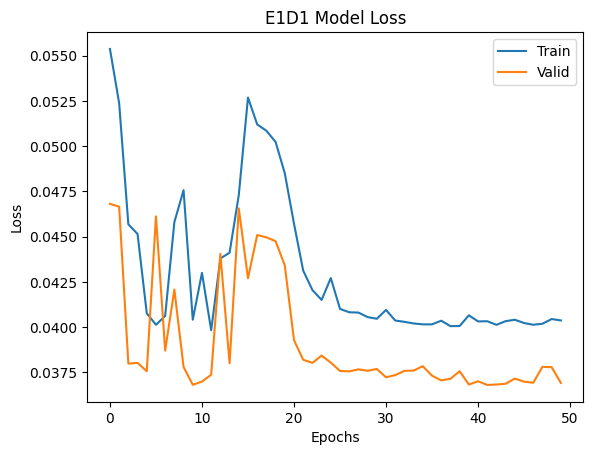

In [38]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

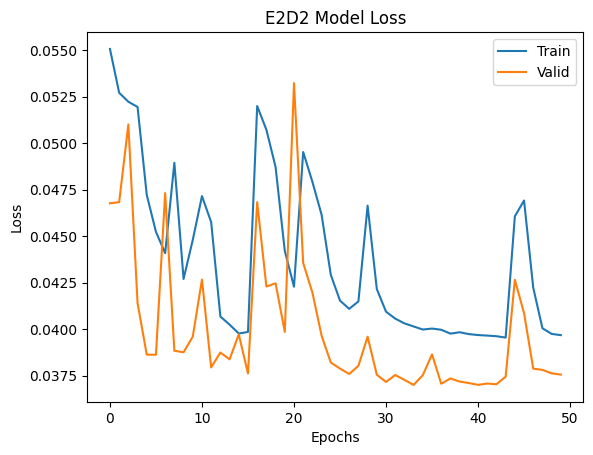

In [39]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [45]:
### Prediction on test samples
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

947/947 [==============================] - 23s 25ms/step


In [46]:
#Inverse Scaling of the predicted values
#Now we will convert the predictions to their original scale.

for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])

    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])

    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [47]:
#Evaluate the result
#Calculate the error of all observations.

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,n_future+1):
    print("Hour ",j,":") # Change it for Day if you decide to use a daily dataset
    print("RMSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index], squared=False),end=", ")
    print("RMSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index], squared=False))
    #print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    #print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()

total_real_power
Day  1 :
MAE-E1D1 :  32.827245106324916, MAE-E2D2 :  33.25801418071374
Day  2 :
MAE-E1D1 :  36.87417223297888, MAE-E2D2 :  36.411971220693104
Day  3 :
MAE-E1D1 :  37.66794856614859, MAE-E2D2 :  37.72013194590629
Day  4 :
MAE-E1D1 :  37.94687501900863, MAE-E2D2 :  38.01886443098735
Day  5 :
MAE-E1D1 :  37.68409810486353, MAE-E2D2 :  37.45001189566774
Day  6 :
MAE-E1D1 :  37.46097516173939, MAE-E2D2 :  37.13840430480422
Day  7 :
MAE-E1D1 :  37.35805491320281, MAE-E2D2 :  37.11337777376001
Day  8 :
MAE-E1D1 :  37.2750306367452, MAE-E2D2 :  37.0422218726465
Day  9 :
MAE-E1D1 :  37.20124807121003, MAE-E2D2 :  37.14400729384687
Day  10 :
MAE-E1D1 :  37.315740787512986, MAE-E2D2 :  37.49988892529634
Day  11 :
MAE-E1D1 :  37.25854603960922, MAE-E2D2 :  37.62259615438488
Day  12 :
MAE-E1D1 :  37.10352012135774, MAE-E2D2 :  37.361270309313035
Day  13 :
MAE-E1D1 :  37.34207101180732, MAE-E2D2 :  37.358803846961045
Day  14 :
MAE-E1D1 :  37.54680597700772, MAE-E2D2 :  37.6840737323